In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, ops
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm

In [4]:
BATCH_SIZE = 32
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40

transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), torchvision.transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])
trainset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

100.0%


Extracting data/FashionMNIST\raw\train-images-idx3-ubyte.gz to data/FashionMNIST\raw



100.0%


Extracting data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/FashionMNIST\raw



100.0%


Extracting data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data/FashionMNIST\raw



100.0%

Extracting data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data/FashionMNIST\raw



In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1060 6GB


In [6]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


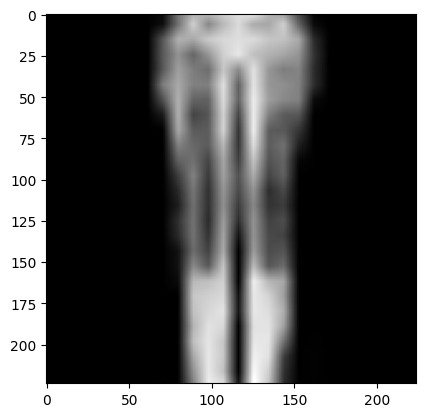

Label: 1


In [9]:
#nex iter gets next 100 images
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[7][0].squeeze()
label = train_labels[7]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [45]:
from torchvision import models
# all_models = models.list_models()
m1 = torchvision.models.get_model("mobilenet_v3_small", num_classes=10, num_channels=1)
# Move your model to the GPU if available
m1.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [26]:
m1_weights = torch.load("model_weights/32_best_model_weights.pth")

In [31]:
# Define the deformable convolutional layer
deform_conv = ops.DeformConv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

# Load the weights from the original convolutional layer
deform_conv.weight.data = m1_weights['features.0.0.weight']
# Replace the original convolutional layer with the deformable convolutional layer
m1.features[0][0] = deform_conv


In [37]:
def replace_conv2d_with_deformable_conv(module):
    for name, child in module.named_children():
        if isinstance(child, torch.nn.Conv2d):
            # Create a deformable convolution layer with the same settings
            deform_conv = ops.DeformConv2d(
                in_channels=child.in_channels,
                out_channels=child.out_channels,
                kernel_size=child.kernel_size,
                stride=child.stride,
                padding=child.padding,
                dilation=child.dilation,
                groups=child.groups,
                bias=child.bias is not None,
            )
            deform_conv.weight = child.weight
            if child.bias is not None:
                deform_conv.bias = child.bias

            # Replace the Conv2d layer with the DeformConv2d layer
            setattr(module, name, deform_conv)
        else:
            # Recursively check children for Conv2d layers
            replace_conv2d_with_deformable_conv(child)

# Call the function to replace Conv2d layers with DeformConv2d layers
replace_conv2d_with_deformable_conv(m1)

In [10]:
batch1, label1=next(iter(trainloader))


In [11]:
# predicted = m1(batch1.to(device))

In [12]:
# Freeze all layers
for param in m1.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in m1.classifier.parameters():
    param.requires_grad = True

In [25]:
import pickle

batch_tr_loss = {}
batch_te_loss = {}

best_test_loss = float('inf')

optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
# Freeze all layers
for param in m1.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in m1.classifier.parameters():
    param.requires_grad = True

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

# epoch loss and accuracy
tr_loss, tr_acc = [], []
te_loss, te_acc = [], []

for t in (range(NUM_OF_EPOCHS)):
    m1.train()
    batch_loss, batch_accuracy = [], []
    print(f"Epoch {t+1} Training...")
    for X,y in tqdm(trainloader):
        X = X.to(device)
        y = y.to(device)
        predicted = m1(X)
        loss = loss_fn(predicted, y)
        batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
        batch_loss.append(float(loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batches = len(batch_loss)
    tr_loss.append(sum(batch_loss)/batches)
    tr_acc.append(sum(batch_accuracy)/batches)

    m1.eval()
    with torch.no_grad():
        batch_loss, batch_accuracy = [], []
        print(f"Epoch {t+1} Testing...")
        for X,y in tqdm(testloader):
            X = X.to(device)
            y = y.to(device)
            predicted = m1(X)
            loss = loss_fn(predicted, y)
            batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
            batch_loss.append(float(loss.item()))

        batches = len(batch_loss)
        te_loss.append(sum(batch_loss)/batches)
        te_acc.append(sum(batch_accuracy)/batches)

    # Save the model's weights after each epoch
    torch.save(m1.state_dict(), f"model_weights/{BATCH_SIZE}_model_weights.pth")

    # Check if the current test loss is the best so far
    if te_loss[-1] < best_test_loss:
        best_test_loss = te_loss[-1]
        # Save the model's weights with the best test loss
        torch.save(m1.state_dict(), f"model_weights/{BATCH_SIZE}_best_model_weights.pth")

    print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc[-1]):>0.2f}%, Train_loss: {tr_loss[-1]:>8f}, Test_accuracy: {(100*te_acc[-1]):>0.2f}%, Test_loss: {te_loss[-1]:>8f}")
batch_tr_loss[BATCH_SIZE] = tr_loss
batch_te_loss[BATCH_SIZE] = te_loss
# Save the dictionary to a file
with open("batch_tr_loss.pkl", 'wb') as file:
    pickle.dump(batch_tr_loss, file)

# Save the dictionary to a file
with open("batch_te_loss.pkl", 'wb') as file:
    pickle.dump(batch_te_loss, file)

Epoch 1 Training...


100%|██████████| 938/938 [01:02<00:00, 14.90it/s]


Epoch 1 Testing...


  0%|          | 0/157 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the dictionaries batch_tr_loss and batch_te_loss with batch sizes as keys

# List of batch sizes
batch_sizes = [8, 16, 32, 64]

# Create subplots for loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

for batch_size in batch_sizes:
    tr_loss = batch_tr_loss[batch_size]
    te_loss = batch_te_loss[batch_size]
    plt.plot(range(1, NUM_OF_EPOCHS + 1), tr_loss, label=f'Training Loss (Batch Size {batch_size})')
    plt.plot(range(1, NUM_OF_EPOCHS + 1), te_loss, label=f'Testing Loss (Batch Size {batch_size})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# Plot the best test loss for each batch size
plt.subplot(1, 2, 2)

for batch_size in batch_sizes:
    best_test_loss = min(batch_te_loss[batch_size])
    plt.plot(batch_size, best_test_loss, 'o', label=f'Best Test Loss (Batch Size {batch_size})')

plt.xlabel('Batch Size')
plt.ylabel('Best Test Loss')
plt.title('Best Test Loss for Different Batch Sizes')
plt.legend()

plt.tight_layout()
plt.show()
